In [2]:

import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
import pandas as pd

map_fn = tf.map_fn

################################################################################
##                           DATASET GENERATION                               ##
##                                                                            ##
##  The problem we are trying to solve is adding two binary numbers. The      ##
##  numbers are reversed, so that the state of RNN can add the numbers        ##
##  perfectly provided it can learn to store carry in the state. Timestep t   ##
##  corresponds to bit len(number) - t.                                       ##
################################################################################

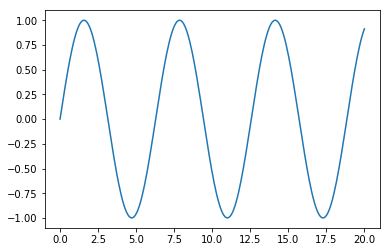

In [44]:
class TimeSeriesData():
    def __init__(self,num_points,xmin,xmax):
        self.xmin=xmin
        self.xmax=xmax
        self.num_points=num_points
        self.resolution=(xmax-xmin)/num_points
        self.x_data=np.linspace(xmin,xmax,num_points)
        self.y_true=np.sin(self.x_data)
        
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,prediction_num,return_batch_ts=False):
        #Random starting point for batch
        random_start=np.random.rand(batch_size,1)
        
        #Put the random point on the time series
        ts_start=random_start*(self.xmax-self.xmin-(steps*self.resolution)) #Trick to convert any number into a point in the time series
        
        
        batch_ts=ts_start+(np.arange(0.0,steps+prediction_num) * self.resolution) #steps +1 because we are predicting just one tme step ahead
        
        y_batch=np.sin(batch_ts)
        
        #Formatting for RNN
        if return_batch_ts:
            return y_batch[:,:-prediction_num].reshape(-1,steps) , y_batch[:,-1].reshape(-1,1), batch_ts
        else:
            return y_batch[:,:-prediction_num].reshape(-1,steps) , y_batch[:,-1].reshape(-1,1) #Returning the sequence shifted over one time step
    
ts_data=TimeSeriesData(250,0,20)
plt.plot(ts_data.x_data,ts_data.y_true)
plt.show()

In [45]:

################################################################################
##                           Batch DEFINITION                                 ##
################################################################################
time_steps=10
prediction_size = 18
batch_size = 125
y1,y2,ts= ts_data.next_batch(125,time_steps,prediction_size,True)

################################################################################
##                           Validation Set DEFINITION                        ##
################################################################################
size_validation = 17
v1,v2,xv      = ts_data.next_batch(size_validation,time_steps,prediction_size,True)


In [47]:
y1.shape

(125, 10)

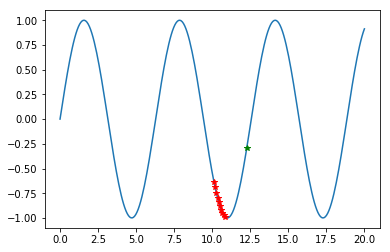

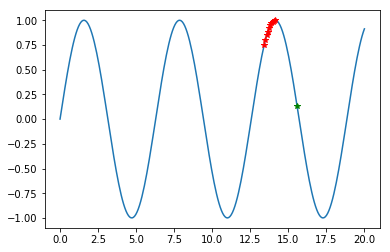

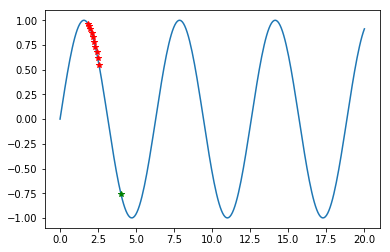

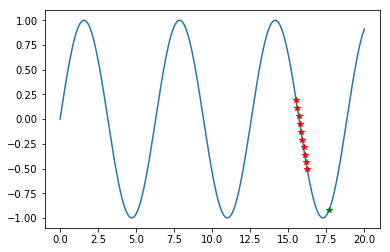

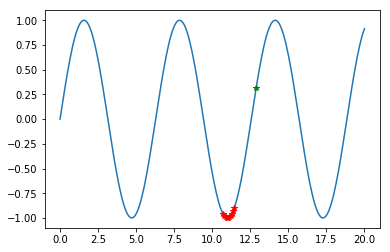

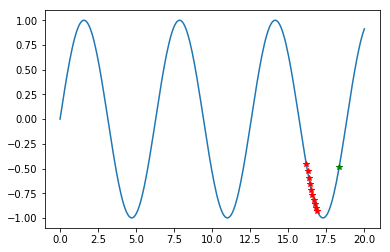

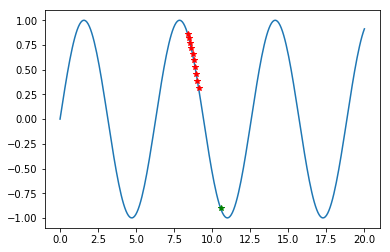

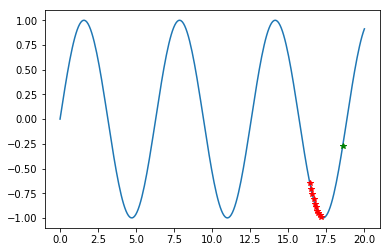

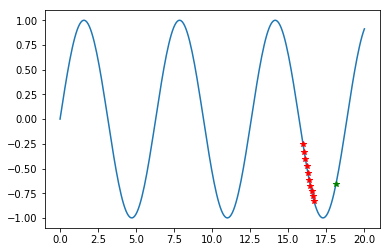

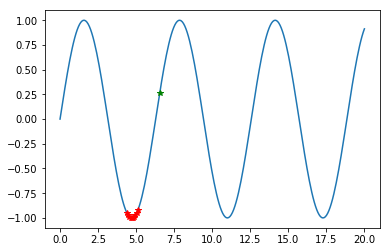

In [4]:
for i in range (0,10):
    plt.plot(ts_data.x_data,ts_data.y_true)
    plt.plot(ts[i][:-prediction_size],y1[i],"r*")
    plt.plot(ts[i][-1],y2[i],"g*")
    plt.show()

In [5]:
################################################################################
##                           GRAPH DEFINITION                                 ##
################################################################################

INPUT_SIZE    = time_steps       
RNN_HIDDEN    = 100
OUTPUT_SIZE   = 1       # 1 bit per timestep
LEARNING_RATE = 0.01
n_layers      = 1
n_iterations  = batch_size - OUTPUT_SIZE
EPOCH         =  15

X = tf.placeholder(tf.float32,[None,INPUT_SIZE,1])
Y = tf.placeholder(tf.float32, (None,OUTPUT_SIZE))



cellForm = [tf.contrib.rnn.BasicLSTMCell(RNN_HIDDEN, activation = tf.nn.relu) for layer in range(n_layers)]
cell= tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.MultiRNNCell(cellForm),output_size=OUTPUT_SIZE )
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

loss = tf.reduce_mean(tf.square(outputs[:,-1,:] - Y))
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()



################################################################################
##                           TRAINING LOOP                                    ##
################################################################################

prediction    = []
with tf.Session() as sess:
    init.run()
    for epoch in range (EPOCH):
        mse = 0
        for iteration in range(n_iterations):
            X_batch, Y_batch = y1[iteration], y2[iteration]
            X_batch = X_batch.reshape(1,INPUT_SIZE,1)
            Y_batch = Y_batch.reshape(1,1)
            #print("\nBatch",X_batch,"\nBatch",Y_batch,"\n")
            sess.run(training_op, feed_dict={X: X_batch, Y: Y_batch})
            #print("Numero de iteraciones: ", iteration,"\n")
        for iteration in range(size_validation):
            vv1, vv2 = v1[iteration], v2[iteration]
            vv1 = vv1.reshape(1,INPUT_SIZE,1)
            vv2 = vv2.reshape(1,1)
            mse += loss.eval(feed_dict={X: vv1, Y: vv2})
            prediction.append(outputs.eval(feed_dict={X: vv1, Y: vv2})[:,-1,:])
        print(epoch, "\tMSE:", mse/size_validation)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
0 	MSE: 0.5897016082616413
1 	MSE: 0.4639670688270331
2 	MSE: 0.46714049709193844
3 	MSE: 0.2193618966467003
4 	MSE: 0.14177171307079228
5 	MSE: 0.1473189796841539
6 	MSE: 0.040398586955461724
7 	MSE: 0.01390693957450019
8 	MSE: 0.0007558783069913154
9 	MSE: 0.0008687185242225122
10 	MSE: 0.0005413934191518125
11 	MSE: 0.0006256919629830757
12 	MSE: 0.00038553080256566744
13 	MSE: 0.00040222829027377027
14 	MSE: 0.00015865676651153937


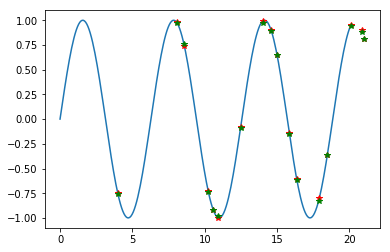

In [6]:
pp = np.array(prediction[-size_validation:])
pp = pp.reshape([size_validation,1])
plt.plot(ts_data.x_data,ts_data.y_true)
plt.plot(xv[:,-1],v2,"r*")
plt.plot(xv[:,-1],pp,"g*")
plt.show()

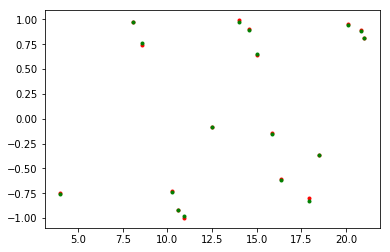

In [7]:
plt.plot(xv[:,-1],v2,"r.")
plt.plot(xv[:,-1],pp,"g.")
plt.show()

In [226]:
################################################################################
##                           LEER DATOS SERIE                                 ##
################################################################################
PERCENTAGE_VALIDATION = 10
NUMBER_TESTING        = 18
STEPS_AHEAD           = 18
WINDOW = 10
training_data = pd.read_excel("NN3_FINAL_DATASET_WITH_TEST_DATA.xlsx",sheet_name="Hoja 1")
Serie_1 = training_data["Serie 1"]

class TimeSeriesNN3():
    def __init__(self,STEPS_AHEAD ,NUMBER_TESTING ,PERCENTAGE_VALIDATION, SERIE, WINDOW):
        self.STEPS_AHEAD = STEPS_AHEAD
        self.WINDOW = WINDOW
        self.NUMBER_TESTING = NUMBER_TESTING
        self.PERCENTAGE_VALIDATION = PERCENTAGE_VALIDATION
        self.SERIE = SERIE
        self.SIZE = SERIE.shape[0]
        self.NUMBER_VALIDATION = 0
        self.NUMBER_TRAINING = self.SIZE - self.NUMBER_TESTING
        if (PERCENTAGE_VALIDATION != 0):
            self.NUMBER_VALIDATION = int(self.NUMBER_TRAINING/self.PERCENTAGE_VALIDATION)
        self.NUMBER_TRAINING_F = self.NUMBER_TRAINING - self.NUMBER_VALIDATION
    
    def divide_testing (self):
        return (self.SERIE[:self.NUMBER_TRAINING],self.SERIE[self.NUMBER_TRAINING:])
    
    def divide_validation (self,serie, random):
        experimentx = np.zeros((self.NUMBER_TRAINING - self.STEPS_AHEAD, self.WINDOW))
        experimenty = np.zeros((self.NUMBER_TRAINING - self.STEPS_AHEAD,1))
        cnt =  0
        cnt2 = 0
        for i in range (experimentx.shape[0]):
            cnt += cnt2
            for j in range (self.WINDOW):
                experimentx[i][j] = self.SERIE[cnt]
                cnt += 1
            experimenty[i] = self.SERIE[cnt + self.STEPS_AHEAD - 1]
            cnt = 0
            cnt2 += 1      
        
        if (random):
            experimentx = np.concatenate((experimentx, experimenty), axis=1)
            experimentx = np.random.permutation(experimentx)
            experimentx, experimenty = np.hsplit(experimentx,[-1])   
            
        if (self.PERCENTAGE_VALIDATION == 0):
            return (experimentx, experimenty, experimentx, experimenty)
        else:
            return (experimentx[:self.NUMBER_TRAINING_F], experimenty[:self.NUMBER_TRAINING_F], experimentx[self.NUMBER_TRAINING_F:], experimenty[self.NUMBER_TRAINING_F:])
    
    
    def batch (self, boolean):
        x,p = self.divide_testing()
        w,x,y,z =self.divide_validation(x,boolean)
        return (w,x,y,z,p)
            
Serie1 = TimeSeriesNN3(STEPS_AHEAD ,NUMBER_TESTING ,PERCENTAGE_VALIDATION, Serie_1,10)
            
    

In [227]:
w,x,y,z,p = Serie1.batch(True)

In [228]:
print(w[2])
print(x[2])

[4806. 4645. 4784. 4979. 4530. 4942. 4651. 5150. 4987. 4532.]
[5067.]


In [192]:
arr = np.arange(9).reshape((3, 3))
arr2 = np.arange(9,12).reshape((3,1))
print(arr.shape)
print(arr2.shape)
np.concatenate((arr, arr2), axis=1)

(3, 3)
(3, 1)


array([[ 0,  1,  2,  9],
       [ 3,  4,  5, 10],
       [ 6,  7,  8, 11]])

In [107]:
l = np.zeros((10))
l[1] = 2
l

array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0.])

In [68]:
np.hsplit(l, [-2])

[array([[ 0,  1,  2,  9],
        [ 3,  4,  5, 12],
        [ 6,  7,  8, 15]]), array([[10, 11],
        [13, 14],
        [16, 17]])]